# **Aula 10 - Deep Learning - Transfer Learning**

## **Objetivos**

* Conhecer e praticar Arquiteturas complexas de Redes Neurais Convolucionais
* Aprendizagem por transferência
* Praticar a classificação de objeto usando framework TensorFlow


## **Definição do Problema**

O dataset "cats_vs_dogs" do TensorFlow é um conjunto de dados amplamente utilizado para tarefas de classificação de imagens binárias de gatos e cachorros. Consiste em milhares de imagens coloridas de gatos e cachorros, onde cada imagem é associada a um rótulo indicando se é um gato ou um cachorro.

O objetivo deste laboratório é aplicar a técnica de Transfer Learning para otimizar o processo de classificação das imagens deste dataset.

Mais informações sobre o dataset: https://www.tensorflow.org/datasets/catalog/cats_vs_dogs?hl=pt-br


## **Roteiro**

### **1 - Carregando as Bibliotecas**

In [ ]:
# Importar as bibliotecas
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

### **1.1 - Criando funções uteis de apoio**

In [ ]:
# Códigos Uteis

# Função para exibir o histórico de treino do modelo
def plot_history(history):
    plt.figure(figsize=(20, 10))  # Aumentamos o tamanho da figura para acomodar os dois subplots

    plt.subplot(1, 2, 1)  # Definimos subplot com 1 linha, 2 colunas e índice 1
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='lower left')

    plt.subplot(1, 2, 2)  # Definimos subplot com 1 linha, 2 colunas e índice 2
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('epoch')
    plt.legend(['acc', 'val_acc'], loc='upper left')

    plt.show()

# Função para exibir algumas imagens do conjunto de dados
def plot_images(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    for i, (img, label) in enumerate(zip(images, labels)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(class_names[label])
        plt.axis("off")
    plt.show()

# Definindo uma funçao para redimensionar as imagens
IMG_SIZE = 160 #  160x160
def format_example(image, label):
  """
  returns an image that is reshaped to IMG_SIZE
  """
  image = tf.cast(image, tf.float32)
  image = (image/255.0)
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

### **2 - Carregando o Dataset**

Para informações sobre como carregar o dataset do Tensor Flow, leia a documentação:

* https://www.tensorflow.org/datasets/overview?hl=pt-br
* https://www.tensorflow.org/datasets/api_docs/python/tfds/load
* https://www.tensorflow.org/datasets/splits?hl=pt-br


In [ ]:
# Carrega o dataset, fazendo a separação dos dados em treino, validaçao e teste
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'CatsVsDogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)


### **3 - Explorando o Dataset**

In [ ]:
print(metadata)

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.0',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul,

In [ ]:
# Mostra as caracteristicas do dataset
print(raw_train)
print(raw_validation)
print(raw_test)
print(metadata.features['label'])

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
ClassLabel(shape=(), dtype=int64, num_classes=2)


### **4 - Analisando os dados**

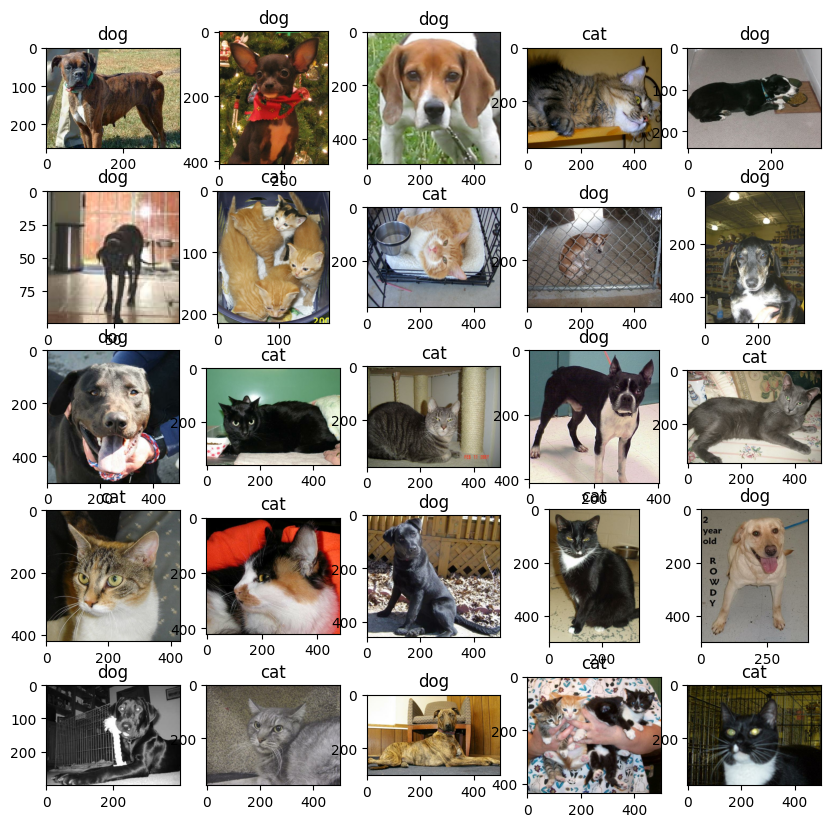

In [ ]:
# Criando uma função para pegar os labels das imagens
get_label_name = metadata.features['label'].int2str

# Mostrando as imagens do dataset
plt.figure(figsize = (10,10))
i = 0
for image, label in raw_train.take(25):
  plt.subplot(5,5,i+1)
  plt.imshow(image)
  plt.title(get_label_name(label))
  i = i + 1

In [ ]:
# Redimensionando as imagens
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

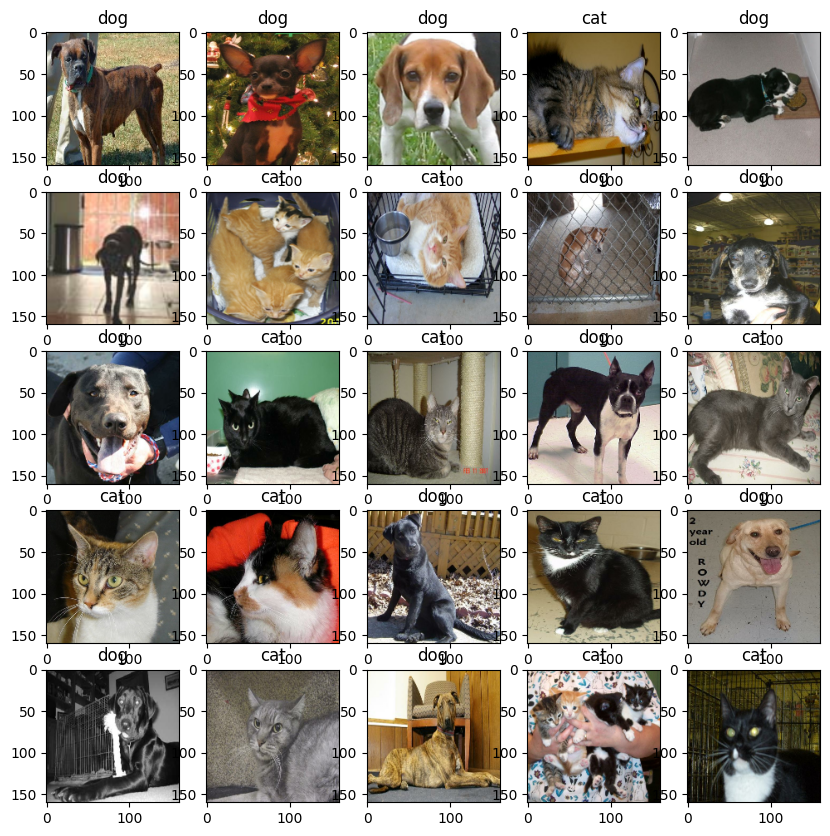

In [ ]:
# Mostrando as imagens do dataset redimensionado
plt.figure(figsize = (10,10))
i = 0
for image, label in train.take(25):
  plt.subplot(5,5,i+1)
  plt.imshow(image)
  plt.title(get_label_name(label))
  i = i + 1


O trecho de código a seguir está definindo dois parâmetros, BATCH_SIZE e SHUFFLE_BUFFER_SIZE, que serão usados para embaralhar e agrupar as imagens do conjunto de dados. Em seguida, o código realiza as seguintes etapas:

* train.shuffle(SHUFFLE_BUFFER_SIZE): Embaralha as imagens de treinamento usando o tamanho do buffer de embaralhamento definido por SHUFFLE_BUFFER_SIZE. Isso ajuda a evitar que o modelo aprenda a sequência específica das imagens durante o treinamento, o que poderia levar a um viés indesejado.

* .batch(BATCH_SIZE): Separa as imagens embaralhadas em batches de tamanho definido por BATCH_SIZE. Isso agrupa várias imagens em cada batch para serem processadas em paralelo durante o treinamento do modelo. O tamanho do batch é uma consideração importante para o desempenho e eficiência do treinamento.

* validation.batch(BATCH_SIZE): Similarmente, as imagens de validação também são agrupadas em batches de tamanho BATCH_SIZE.

* test.batch(BATCH_SIZE): Da mesma forma, as imagens de teste são agrupadas em batches de tamanho BATCH_SIZE.

Essas etapas são comuns em treinamento de modelos de aprendizado de máquina, onde os dados são embaralhados e agrupados em batches para otimizar o processo de treinamento e avaliação do modelo.

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

#embaralha as imagens e separa em batchs
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

### **5 - Criando o Modelo**

#### **Escolhendo um modelo pré-treinado**
A MobileNet V2 desenvolvido no Google e foi treinado com 1,4 milhão de imagens e possui 1000 classes diferentes com pesos predeterminados do imagenet (Googles dataset).

Carregue a rede neural pré-treinada sem a camada de classificação final. Isso pode ser feito usando o argumento include_top=False

In [ ]:
IMG_SIZE = 160
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Cria o base_model referente a MobileNet V2, sem a camada de classificação
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                               include_top = False,
                                               weights = 'imagenet')

In [ ]:
# Mostrando a arquitetura do modelo
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_4[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

Vamos analisar os parametros do nosso modelo:

* Total params: 2,257,984
* Trainable params: 2,223,872
* Non-trainable params: 34,112

Ele está dizendo que temos pouco mais de 2 milhoes de parâmetros, sendo que cerca de 34 mil não permitem treinamento, nos restando aproximadamente 2 milhões que podem ser treinados.

Mas a vantagem de usar essa rede é justamente aproveitar os pesos que já foram treinados, e não retreina-los! Precisamos congelar os pesos originais para evitar o processo de treino novamente.

In [ ]:
#Congela a base_model para não atuaizar os pesos quando treinar.
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_4[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

#### **Adicionando um Classificador**

Até o momento só carregamos uma CNN pré treinada, mas note que ela só tem as camadas de convolução, pooling e outras técnicas aplicadas a CNN. Ela não possui a ultima camada de classificação!

É nessa camada em que é realizada a especificação do nosso modelo, por isso, precisamos incluir agora as camadas de classificação:

In [ ]:
# Camada  para gerar um vetor de 1280 elementos
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# O Classificador para gato ou cachorro com 1 neuronio
prediction_layer = keras.layers.Dense(1)
# Por fim, vamos criar a nossa rede neural com o modelo CNN e com as camadas de classificação que definimos
model = tf.keras.Sequential([
  base_model,           #### cnn mobilenet
  global_average_layer, ###  flatten
  prediction_layer      ###  especiallista
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


**Pronto! Já criamos a nossa rede para classificação. Agora podemos compilar, treinar e testar a nossa rede.** 😀

### **6 - Compilando o Modelo**

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


### **6.1 - Avaliando o modelo antes do treino especifio**

In [ ]:
#Avaliação do modelo antes de treiná-lo com novas imagens
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 3s 43ms/step - loss: 1.1489 - accuracy: 0.4469


Bem ruim né? Isso porquê o nosso classificador não foi treinado para as imagens do nosso dataset

### **7 - Treinando o Modelo**

In [ ]:
tf.random.set_seed(42)
initial_epochs = 6
# Treinamento da nova CNN
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 38s 59ms/step - loss: 0.3000 - accuracy: 0.8488 - val_loss: 0.1144 - val_accuracy: 0.9570
Epoch 2/6
582/582 [==============================] - 34s 56ms/step - loss: 0.0944 - accuracy: 0.9636 - val_loss: 0.0846 - val_accuracy: 0.9690
Epoch 3/6
582/582 [==============================] - 35s 59ms/step - loss: 0.0762 - accuracy: 0.9711 - val_loss: 0.0749 - val_accuracy: 0.9703
Epoch 4/6
582/582 [==============================] - 34s 56ms/step - loss: 0.0687 - accuracy: 0.9738 - val_loss: 0.0697 - val_accuracy: 0.9742
Epoch 5/6
582/582 [==============================] - 34s 56ms/step - loss: 0.0642 - accuracy: 0.9753 - val_loss: 0.0665 - val_accuracy: 0.9746
Epoch 6/6
582/582 [==============================] - 37s 61ms/step - loss: 0.0612 - accuracy: 0.9767 - val_loss: 0.0644 - val_accuracy: 0.9755


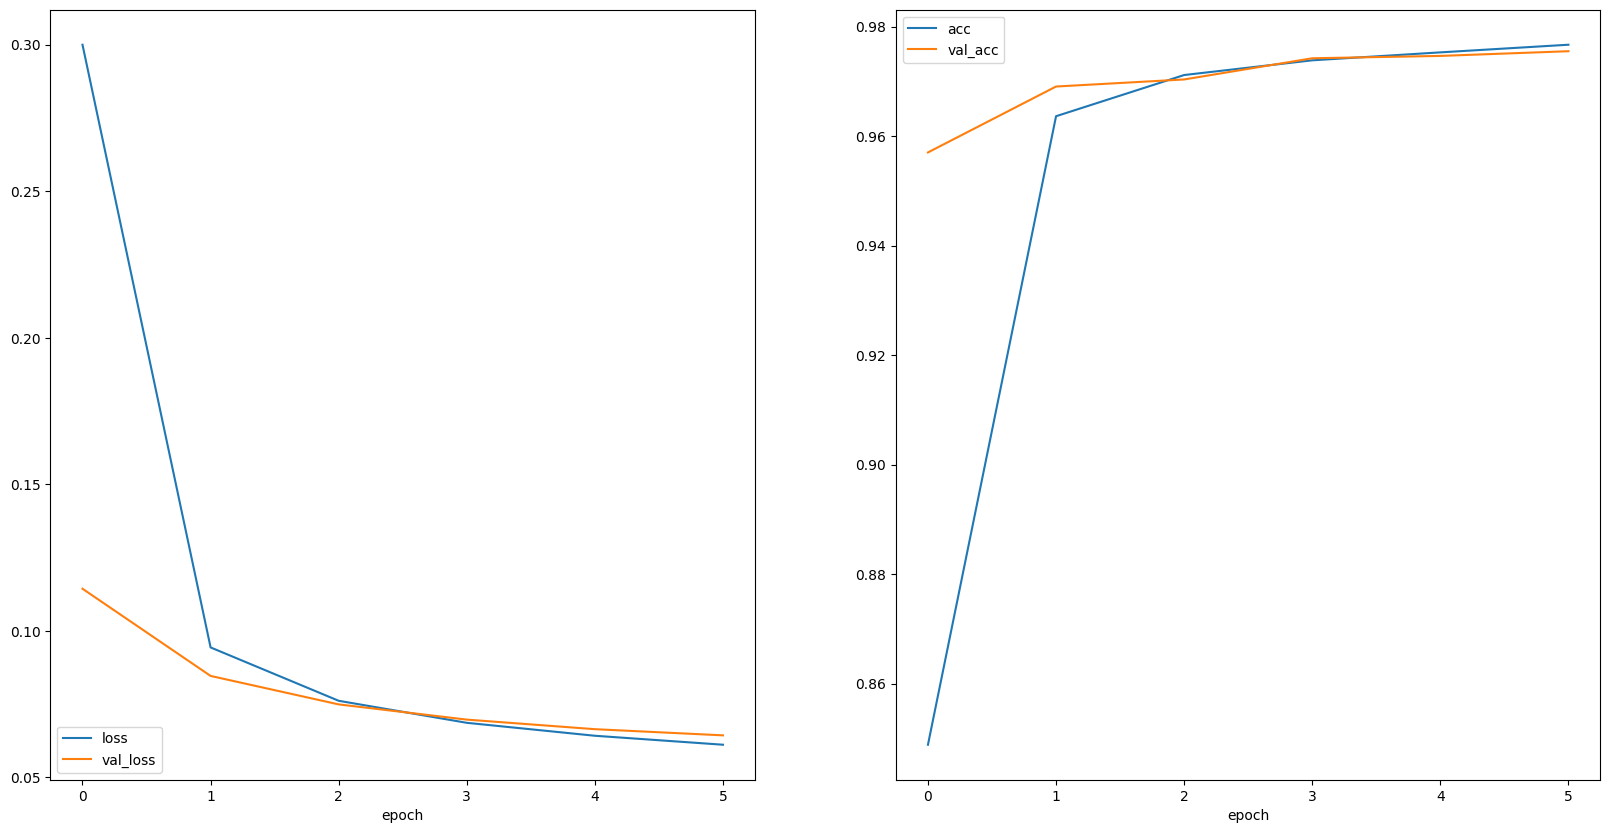

In [ ]:
# Plotando a acuracia e a Loss
plot_history(history)

## **Fazendo Predições**

In [ ]:
# Selecionando algumas imagens do set de teste
image_batch, label_batch = test_batches.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Aplique um sigmoide, pois nosso modelo retorna logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

Predictions:
 [0 1 1 0 0 0 1 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0]
Labels:
 [0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0]


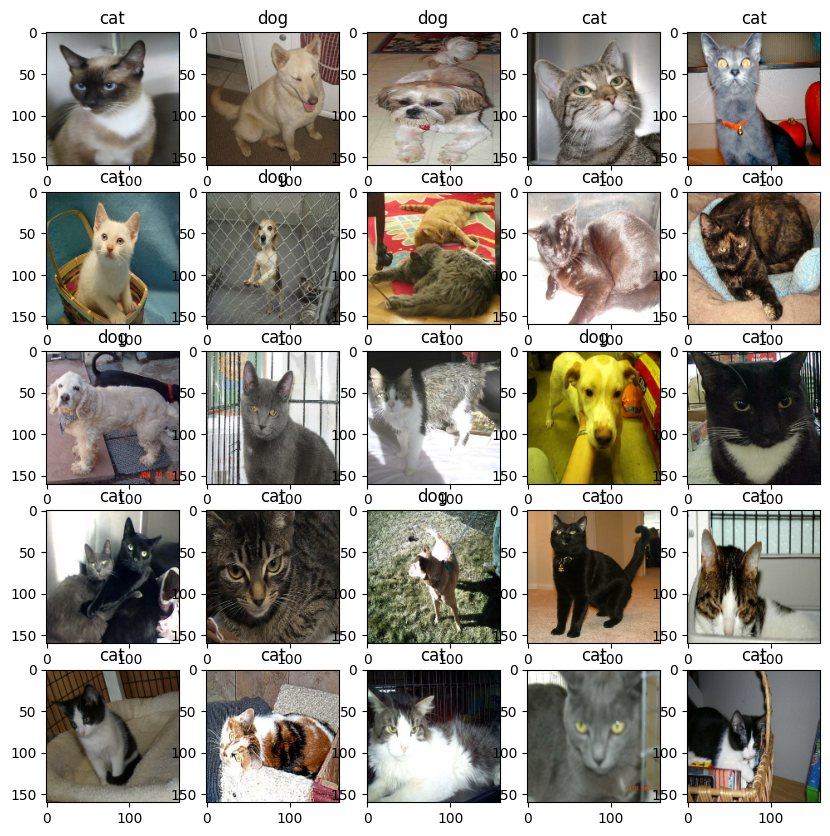

In [ ]:
# Mostrando as imagens do dataset
plt.figure(figsize = (10,10))
i = 0
for image, label in test.take(25):
  plt.subplot(5,5,i+1)
  plt.imshow(image)
  plt.title(get_label_name(label))
  i = i + 1

## **Salvando o modelo**

In [ ]:
# Salvando a rede
model.save("dogs_vs_cats.h5")

#Carregando uma rede .h5
new_model = tf.keras.models.load_model('dogs_vs_cats.h5')

# **EXERCICIO**

Utilizando o modelo salvo no passo anterior, escreva uma função que recebe uma imagem e retorna se é um cachorro ou um gato. Teste a sua função com imagens de gatos e cachorros da internet. Não esqueça de redimensionar as images para o tamanho usado no treino do modelo.

1/1 [==============================] - 1s 1s/step


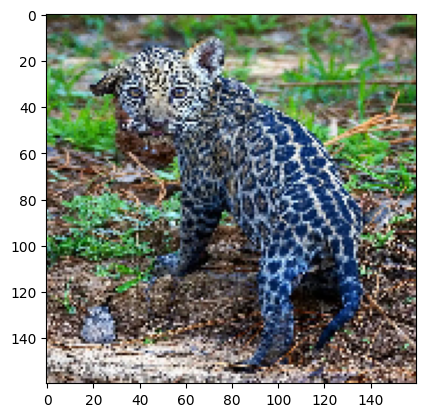

A imagem é um gato.


In [ ]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Carregar o modelo salvo
modelo = load_model('dogs_vs_cats.h5')

def classificar_imagem(caminho_imagem):
    # Carregar a imagem e redimensionar para o tamanho usado no treino do modelo
    img = image.load_img(caminho_imagem, target_size=(160, 160))

    # Converter a imagem para um array numpy e adicionar uma dimensão extra
    img_array = image.img_to_array(img)
    img_array = (img_array / 127.5) - 1  # Normalizar a imagem
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)

    # Fazer a previsão usando o modelo
    predicao = modelo.predict(img_array_expanded_dims)

    # Exibir a imagem
    plt.imshow(img)
    plt.show()

    # Retornar 'cachorro' ou 'gato' dependendo da previsão do modelo
    if predicao[0][0] > 0.5:
        return 'cachorro'
    else:
        return 'gato'

# Substitua o caminho da imagem pelo caminho da imagem que você deseja classificar
image_path = 'filhote.webp'
predicted_class = classificar_imagem(image_path)
print(f"A imagem é um {predicted_class}.")


In [ ]:
# from keras.models import load_model
# from keras.preprocessing import image
# import numpy as np
# import matplotlib.pyplot as plt

# # Carregar o modelo salvo
# modelo = load_model('dogs_vs_cats.h5')

# def classificar_imagem(caminho_imagem):
#     # Carregar a imagem e redimensionar para o tamanho usado no treino do modelo
#     img = image.load_img(caminho_imagem, target_size=(160, 160))

#     # Converter a imagem para um array numpy e adicionar uma dimensão extra
#     img_array = image.img_to_array(img)
#     img_array_expanded_dims = np.expand_dims(img_array, axis=0)

#     # Fazer a previsão usando o modelo
#     predicao = modelo.predict(img_array_expanded_dims)

#     # Exibir imagem
#     plt.imshow(img)
#     plt.show()

#     # Retornar 'cachorro' ou 'gato' dependendo da previsão do modelo
#     if predicao[0][0] > 0.5:
#         return 'cachorro'
#     else:
#         return 'gato'
# print(classificar_imagem('gato.jpg'))